# Finalizing Data for Modeling

In [7]:
import astral, datetime as dt, graphviz, json, math, matplotlib.pyplot as plt, \
       missingno as msno, multiprocessing, numpy as np, os, pandas as pd, \
       regex as re, requests, seaborn as sns, xgboost as xgb

from astral                  import LocationInfo, moon
from astral.sun              import sun
from datetime                import datetime, timedelta
from functools               import reduce
from joblib                  import Parallel, delayed
from scipy.stats             import randint, uniform
from sklearn.ensemble        import ExtraTreesRegressor, RandomForestClassifier, \
                                    RandomForestRegressor
from sklearn.experimental    import enable_iterative_imputer
from sklearn.impute          import IterativeImputer, KNNImputer, \
                                    MissingIndicator, SimpleImputer
from sklearn.linear_model    import BayesianRidge, SGDRegressor
from sklearn.metrics         import accuracy_score, f1_score, make_scorer, \
                                    mean_absolute_error, mean_squared_error, \
                                    precision_score, r2_score, recall_score, \
                                    roc_auc_score
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, \
                                    RandomizedSearchCV, StratifiedKFold, \
                                    train_test_split
from sklearn.pipeline        import FeatureUnion, make_pipeline
from sklearn.preprocessing   import LabelEncoder, StandardScaler
from sklearn.tree            import DecisionTreeRegressor
from tqdm.auto               import tqdm
from tune_sklearn            import TuneSearchCV, TuneGridSearchCV

## for progress bars
tqdm.pandas()
## use regex to find latest iteration of files
def latest_file(filename, prefix_path = 'Data/New Data', filetype = 'csv'):
    file_re = r'^' + filename + '_\d{4}\-\d{2}\-\d{2}\.' + filetype + '$'
    data_file_path = list(sorted([i for i in os.listdir(prefix_path) \
                                  if re.match(file_re, i)]))[-1]
    return prefix_path + '/' + data_file_path
output_str = 'Data/New Data/{}_{}.csv'
curr_date  = datetime.now().strftime('%Y-%m-%d')

In [8]:
## setting up data for modeling 
data     = pd.read_csv(latest_file('final_data'), low_memory = False).set_index('id')
zipcodes = pd.read_csv(latest_file('zipcodes'),   low_memory = False).iloc[:, 1:]

dates_and_coords = pd.read_csv(latest_file('dates_and_coords'),   low_memory = False)\
                     .rename(columns = {'Unnamed: 0': 'id'}).set_index('id')
weather_data     = pd.read_csv(latest_file('fixed_weather_data'), low_memory = False)\
                     .rename(columns = {'Unnamed: 0': 'id'}).set_index('id')

## day or night binary categorical variable
def find_daynight(df_row):
    ## returns binary dummy variable for day (0) or night (1)
    loc_dt_s   = datetime.strptime(df_row['date_start'], '%Y-%m-%d %H:%M:%S.%f')
    loc_dt_e   = datetime.strptime(df_row['date_end'],   '%Y-%m-%d %H:%M:%S.%f')
    if loc_dt_s.date() != loc_dt_e.date():
        return 1
    astral_loc = LocationInfo("", "", "", df_row['lat'], df_row['lon'])
    loc_sun    = sun(astral_loc.observer, date = loc_dt_e)
    
    try:
        if (loc_dt_e <  loc_sun['sunrise'].replace(tzinfo = None)) | \
           (loc_dt_e >= loc_sun['sunset'].replace(tzinfo  = None)):
            return 1
        else:
            return 0
    except:
        return np.nan
    
dates_and_coords['cat_night'] = dates_and_coords.progress_apply(lambda x: find_daynight(x), axis = 1)

## combine data into one dataset
data_drop_cols = ['ac_vessels_used', 'cat_rain', 'cat_snow', 'datetime_found', \
                  'datetime_notif', 'init_datetime', 'county', 'dist_km', \
                  'final_coords', 'init_coords', 'sex', 'total_cost', 'zip']
dt_c_drop_cols = ['date_start', 'date', 'date_end', 'zip', 'state', 'station']

more_vars  = dates_and_coords.drop(columns = dt_c_drop_cols)
model_data = data.drop(columns = data_drop_cols)\
                 .join(weather_data, how = 'left')\
                 .join(more_vars,    how = 'left')\
                 .replace({i: {0: np.nan} for i in \
                           weather_data.columns if \
                           i.startswith('temp')})

model_data.to_csv(output_str.format('model_data', curr_date))
model_data.head(10).style.background_gradient()

  0%|          | 0/6006 [00:00<?, ?it/s]

,age,cat_animal,cat_child,cat_health,cat_missingrunaway,cat_outdoors,cat_overdue,cat_vehicle,cat_water,cat_work,dist_mi,eco_div,outcome,population_density,state,terrain,total_hrs,total_notify_hrs,total_search_hrs,temp_max,temp_min,temp_avg,rain,snow_depth,year,month,season,lat,lon,cat_night
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AZ00000,-9.234413,0,0,0,0,0,0,0,0,0,nan,320.000000,0.000000,11.800000,AZ,flat,7.083333,0.000000,7.083333,41.100000,17.800000,41.100000,0.000000,0.000000,2005.000000,7.000000,spring,32.711300,-109.584110,1.000000
AZ00001,40.000000,0,0,1,0,0,0,0,0,0,7.762276,320.000000,0.000000,183.600000,AZ,flat,4.500000,0.000000,4.500000,38.300000,21.700000,38.300000,0.000000,0.000000,2005.000000,7.000000,spring,31.434933,-110.232333,1.000000
AZ00002,75.000000,0,0,0,0,1,0,0,0,0,11.529114,310.000000,0.000000,5.000000,AZ,mountain,10.000000,0.000000,10.000000,37.200000,11.700000,37.200000,0.000000,0.000000,2005.000000,7.000000,spring,33.971817,-109.095033,1.000000
AZ00003,4.000000,0,1,0,0,0,0,0,0,0,1.268968,310.000000,0.000000,5.000000,AZ,mountain,8.500000,0.000000,8.500000,37.200000,13.300000,37.200000,0.000000,0.000000,2005.000000,7.000000,spring,33.821200,-109.149183,1.000000
AZ00004,63.000000,0,0,0,0,1,0,0,0,0,4.171026,310.000000,0.000000,10.700000,AZ,flat,1.000000,0.000000,1.000000,41.100000,11.700000,41.100000,0.000000,0.000000,2005.000000,7.000000,spring,34.458783,-111.250883,1.000000
AZ00005,33.000000,0,0,0,0,1,0,0,0,0,nan,310.000000,0.000000,18.400000,AZ,mountain,1.000000,0.000000,1.000000,41.100000,11.700000,41.100000,0.000000,0.000000,2005.000000,7.000000,spring,35.326533,-111.688433,1.000000
AZ00006,51.000000,0,0,0,0,0,0,0,0,0,nan,320.000000,0.000000,11.800000,AZ,flat,19.000000,0.000000,19.000000,13.900000,-12.800000,13.900000,0.000000,0.000000,2005.000000,7.000000,spring,32.738133,-109.569217,1.000000
AZ00007,5.000000,0,1,0,0,0,0,0,0,0,9.817553,320.000000,0.000000,183.600000,AZ,flat,13.000000,0.000000,13.000000,33.300000,9.400000,22.500000,0.000000,0.000000,2005.000000,7.000000,spring,31.700550,-109.498167,1.000000
AZ00008,49.000000,0,0,0,0,1,0,0,0,0,4.335133,320.000000,0.000000,183.600000,AZ,flat,3.000000,0.000000,3.000000,42.200000,26.100000,42.200000,0.000000,0.000000,2005.000000,7.000000,spring,31.902400,-109.278467,1.000000


<AxesSubplot:>

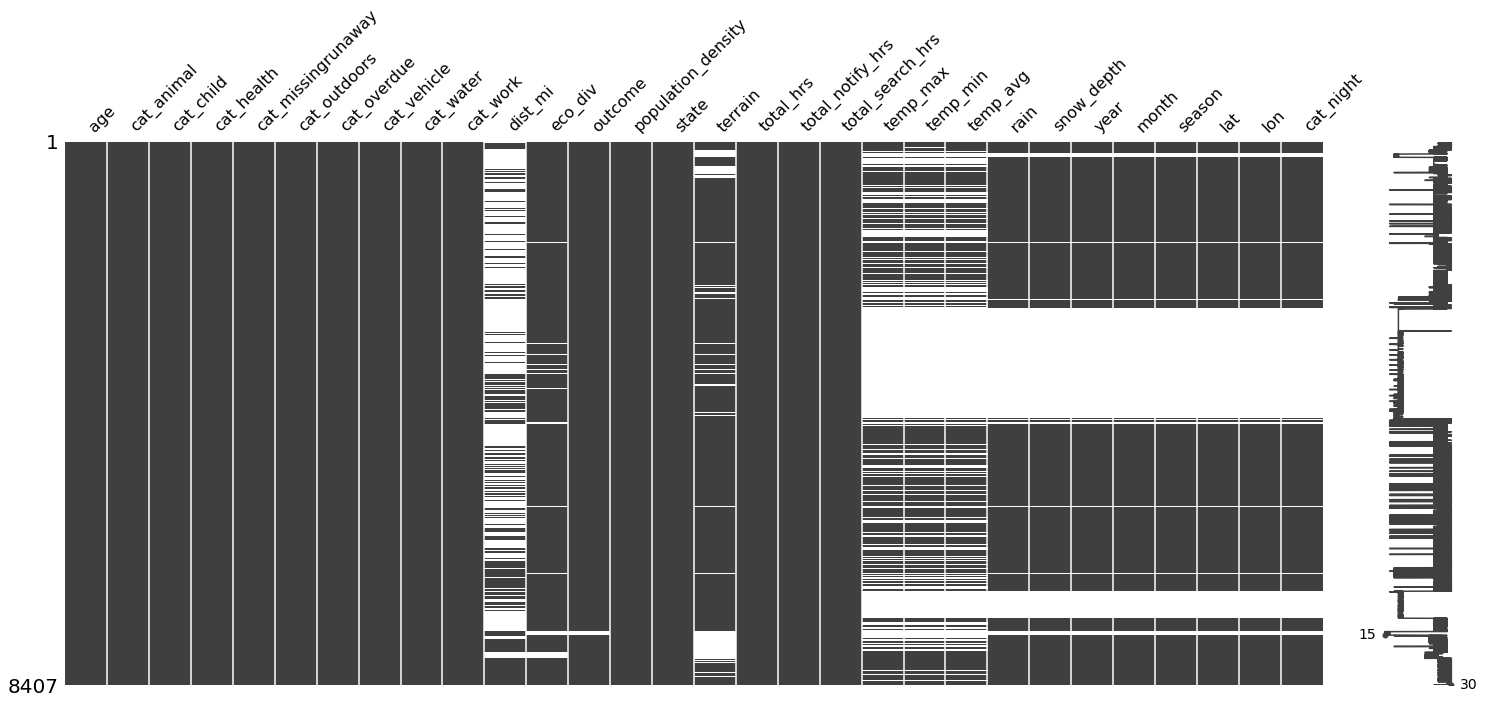

In [3]:
msno.matrix(model_data)

<AxesSubplot:>

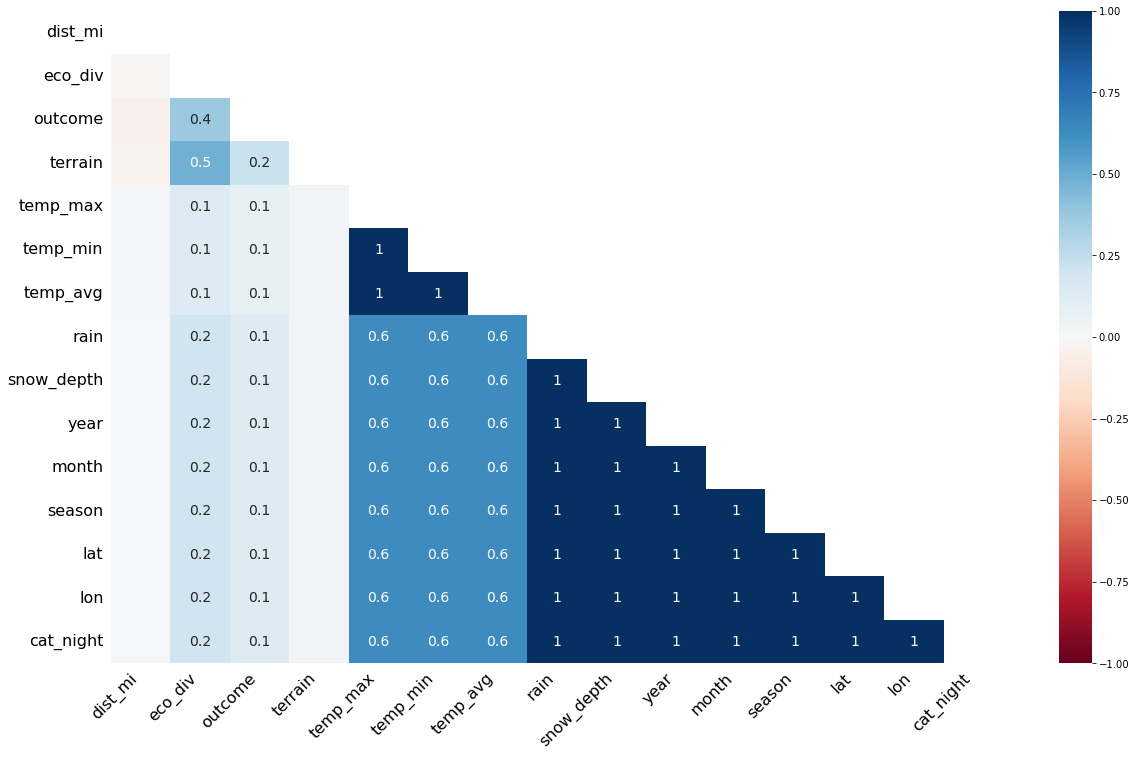

In [4]:
msno.heatmap(model_data)

<AxesSubplot:>

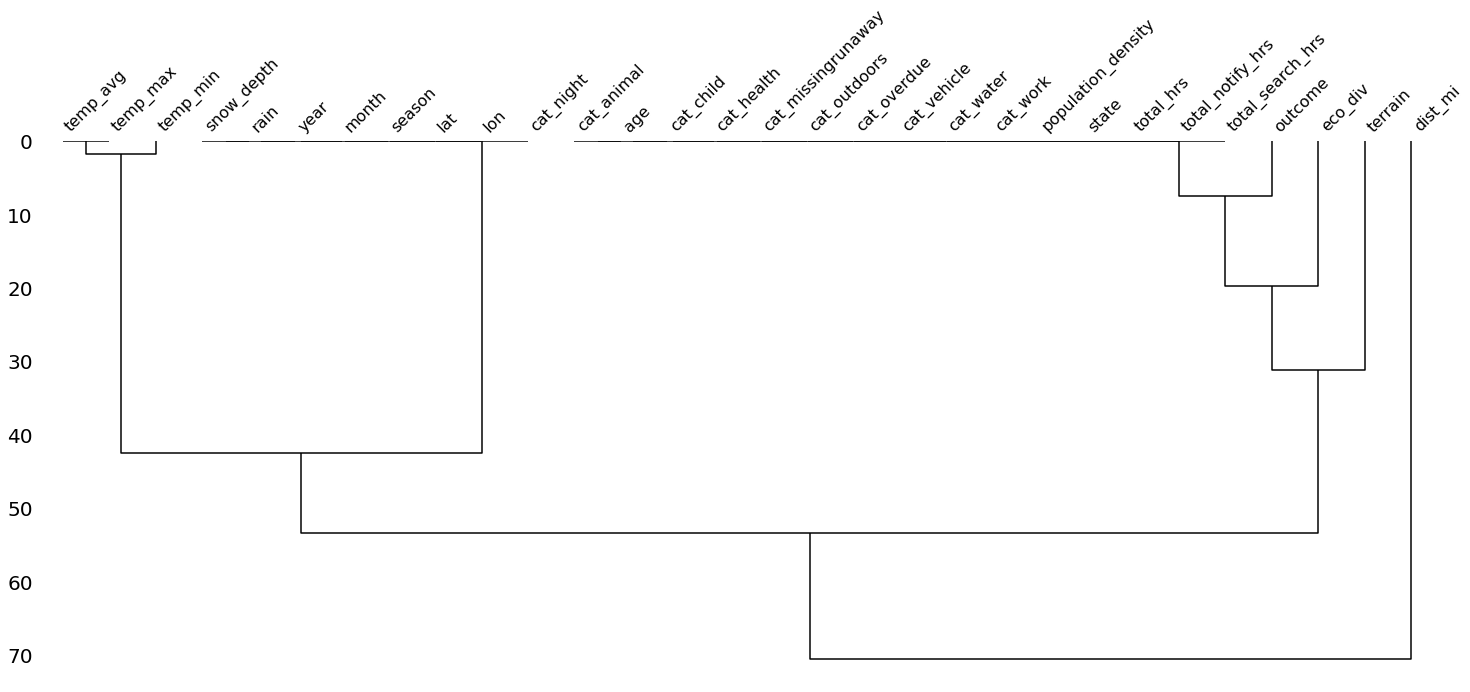

In [5]:
msno.dendrogram(model_data)

In [ ]:
pd.concat([model_data.isna().sum(), model_data.isna().mean()], axis = 1).replace({0: np.nan}).dropna().sort_index()

In [6]:
## convert categorical (string) variables to int
eco_div_map  = {val: idx for idx, val in \
                enumerate(model_data['eco_div']\
                         .dropna().unique())}
season_map   = {'spring': 0, 'summer': 1, \
                'fall':   2, 'winter': 3}
state_map    = {val: idx for idx, val in \
                enumerate(model_data['state'].dropna()\
                         .sort_values().unique())}
terrain_map  = {val: idx for idx, val in \
                enumerate(model_data['terrain'].dropna()\
                         .sort_values().unique())}

model_data['eco_div'] = model_data['eco_div'].replace(eco_div_map)
model_data['season']  = model_data['season'].replace(season_map)
model_data['state']   = model_data['state'].replace(state_map)
model_data['terrain'] = model_data['terrain'].replace(terrain_map)
## savea a version with categories changed to numeric values
model_data.to_csv(output_str.format('model_data_catnumeric', curr_date))

cat_cols = [i for i in model_data.columns if i.startswith('cat')] + \
           ['eco_div', 'month', 'outcome', 'season', 'state', 'terrain', 'year']
num_cols = [i for i in model_data.columns if i.startswith('total') | i.startswith('temp')] + \
           ['age', 'population_density', 'rain', 'snow_depth', 'lat', 'lon']

## version of `model_data` dataset with categorical-coded variables
## encoding categorical variables
model_data_cat = model_data.copy()
for col in cat_cols:
    model_data_cat[col] = model_data_cat[col].astype('category')
    label = LabelEncoder()
    label.fit(list(model_data_cat[col].values))
    model_data_cat[col] = label.transform(list(model_data_cat[col].values))

knn_impute_data = model_data.copy()
knn_impute_data.loc[:, :] = KNNImputer(n_neighbors = 1).fit_transform(knn_impute_data)
knn_impute_data[cat_cols] = knn_impute_data[cat_cols].round(0)
knn_impute_data.to_csv(output_str.format('knn_impute_data', curr_date))

## version of `knn_impute_data` dataset with categorical-coded variables
## encoding categorical variables
knn_impute_data_cat = knn_impute_data.copy()
for col in cat_cols:
    knn_impute_data_cat[col] = knn_impute_data_cat[col].astype('category')
    label = LabelEncoder()
    label.fit(list(knn_impute_data_cat[col].values))
    knn_impute_data_cat[col] = label.transform(list(knn_impute_data_cat[col].values))

rf_impute_data = model_data.copy()
rf_impute_data.loc[:, cat_cols] = IterativeImputer(RandomForestClassifier(n_estimators = 100, n_jobs = -1), max_iter = 50)\
                                 .fit_transform(rf_impute_data[cat_cols])
rf_impute_data.loc[:, num_cols] = IterativeImputer(RandomForestRegressor(n_estimators  = 100, n_jobs = -1), max_iter = 50)\
                                 .fit_transform(rf_impute_data[num_cols])
rf_impute_data.to_csv(output_str.format('rf_impute_data', curr_date))
for col in cat_cols:
    rf_impute_data[col] = rf_impute_data[col].astype('category')
    label = LabelEncoder()
    label.fit(list(rf_impute_data[col].values))
    rf_impute_data[col] = label.transform(list(rf_impute_data[col].values))

#missing_data = model_data.copy()
#missing_data = MissingIndicator().fit_transform(missing_data)

#missing_knn_impute_data = model_data.copy()
#missing_knn_transformer = FeatureUnion(transformer_list = [('features',   KNNImputer(n_neighbors = 1)), \
#                                                           ('indicators', MissingIndicator())])
#missing_knn_impute_data = missing_knn_transformer.fit_transform(missing_knn_impute_data)
# make_pipeline(transformer, [model]).fit(X_train, y_train).predict(X_test)

KeyboardInterrupt: 

In [ ]:
model_data_cat.loc[~model_data_cat['dist_mi'].isna(), :].drop(['dist_mi', 'outcome'], axis = 1)

# Modeling

In [9]:
model_data      = pd.read_csv(latest_file('model_data'),            low_memory = False)\
                    .set_index('id').drop('outcome', axis = 1)
model_data_cat  = pd.read_csv(latest_file('model_data_catnumeric'), low_memory = False)\
                    .set_index('id').drop('outcome', axis = 1)
knn_impute_data = pd.read_csv(latest_file('knn_impute_data'),       low_memory = False)\
                    .set_index('id').drop('outcome', axis = 1)
rf_impute_data  = pd.read_csv(latest_file('rf_impute_data'),        low_memory = False)\
                    .set_index('id').drop('outcome', axis = 1)

def convert_categorical(df, list_cats):
    for col in list_cats:
        df[col] = df[col].astype('category')
        label = LabelEncoder()
        label.fit(list(df[col].values))
        df[col] = label.transform(list(df[col].values))
    return df
## excluding 'outcome'
cat_cols = [i for i in model_data.columns if i.startswith('cat')] + \
           ['eco_div', 'month', 'season', 'state', 'terrain', 'year']
num_cols = [i for i in model_data.columns if i.startswith('total') | i.startswith('temp')] + \
           ['age', 'population_density', 'rain', 'snow_depth', 'lat', 'lon']

model_data_cat  = convert_categorical(model_data_cat,  cat_cols)
knn_impute_data = convert_categorical(knn_impute_data, cat_cols)
rf_impute_data  = convert_categorical(rf_impute_data,  cat_cols)

<AxesSubplot:>

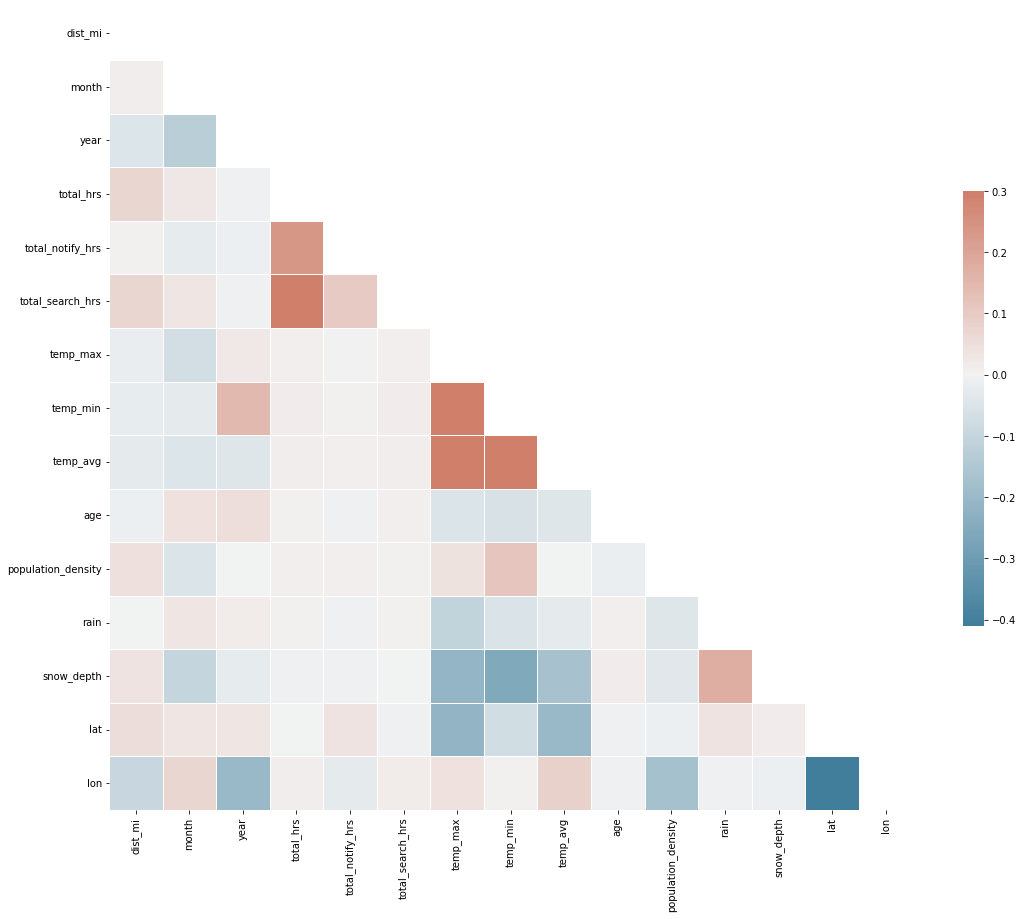

In [10]:
# Compute the correlation matrix
corr = model_data[['dist_mi', 'month', 'season', 'state', 'terrain', 'year'] + num_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Standard Data, Random Forest Regression

In [ ]:
Xc = model_data_cat.loc[~model_data_cat['dist_mi'].isna(), :].drop('dist_mi', axis = 1)
yc = model_data_cat.loc[~model_data_cat['dist_mi'].isna(), 'dist_mi']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size = 0.2, random_state = 1000)
# XYc_dmatrix = xgb.DMatrix(Xc, yc, enable_categorical = True, missing = np.NaN)

scores = {'var':  'explained_variance', 
          'mae':  'neg_mean_absolute_error',
          'rmse': 'neg_root_mean_squared_error',
          'r2':   'r2'}

# param_distributions = {
#     'learning_rate': uniform(), 
#     'max_depth':     randint(2,   10), 
#     'n_estimators':  randint(100, 500), 
#     'reg_alpha':     uniform(0,   100)
# }

param_distributions = {
    'learning_rate': [0.7130830849521742], 
    'max_depth':     [5], 
    'n_estimators':  [108], 
    'reg_alpha':     uniform()
} 

rf_xgb0 = xgb.XGBRFRegressor(tree_method = 'gpu_hist',      enable_categorical = True, \
                             predictor   = 'gpu_predictor', random_state       = 1000)

tune_search0 = TuneSearchCV(rf_xgb0, param_distributions, use_gpu = True, \
                            n_trials = 200, verbose = 2, time_budget_s = 1800, \
                            scoring  = scores, refit = 'r2')
tune_search0.fit(Xc_train, yc_train)

rf_xgb_pred   = tune_search0.predict(Xc_test)
rf_xgb_params = tune_search0.best_params_

## metrics
rf_xgb_mae  = mean_absolute_error(yc_test, rf_xgb_pred)
rf_xgb_mse  = mean_squared_error(yc_test,  rf_xgb_pred)
rf_xgb_rmse = mean_squared_error(yc_test,  rf_xgb_pred, squared = False)
rf_xgb_r2   = r2_score(yc_test, rf_xgb_pred)

print("MAE:  {:.5f}".format(rf_xgb_mae))
print("MSE:  {:.5f}".format(rf_xgb_mse))
print("RMSE: {:.5f}".format(rf_xgb_rmse))
print("R\u00b2:   {:.5f}".format(rf_xgb_r2))

In [ ]:
rf_xgb_params

In [ ]:
Xc = model_data_cat.loc[~model_data_cat['dist_mi'].isna(), :].drop('dist_mi', axis = 1)
yc = model_data_cat.loc[~model_data_cat['dist_mi'].isna(), 'dist_mi']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size = 0.2, random_state = 1000)
rf_xgb0 = xgb.XGBRFRegressor(learning_rate=0.7392823950407534, n_estimators=132, n_jobs=16, max_depth=1, \
                             predictor='gpu_predictor', random_state=1000, reg_alpha=0.10562867745011795, \
                             tree_method='gpu_hist')
rf_xgb0.fit(Xc_train, yc_train)
rf_xgb0_pred = rf_xgb0.predict(Xc_test)
print("MAE:  {:.5f}".format(mean_absolute_error(yc_test, rf_xgb0_pred)))
print("MSE:  {:.5f}".format(mean_squared_error(yc_test,  rf_xgb0_pred)))
print("RMSE: {:.5f}".format(mean_squared_error(yc_test,  rf_xgb0_pred, squared = False)))
print("R\u00b2:   {:.5f}".format(r2_score(yc_test, rf_xgb0_pred)))
rf_xgb0.save_model("rf0.json")

In [ ]:
rf_xgb0.get_booster().feature_names

In [ ]:
rf_xgb0.feature_importances_

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
xgb.plot_importance(rf_xgb0, importance_type = 'weight', max_num_features = 10)

In [ ]:
plt.rcParams['figure.figsize'] = (20, 80)
xgb.plot_tree(rf_xgb0)

In [ ]:
tune_search0.best_estimator_.save_model("rf0.json")
print(tune_search0.best_estimator_)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
xgb.plot_importance(tune_search0.best_estimator_, importance_type = 'weight', max_num_features = 10)

In [ ]:
plt.rcParams['figure.figsize'] = (20, 80)
xgb.plot_tree(tune_search0.best_estimator_)

### KNN (k = 1) Imputed Data, Random Forest Regression

In [ ]:
Xck = knn_impute_data.drop('dist_mi', axis = 1)
yck = knn_impute_data['dist_mi']
Xck_train, Xck_test, yck_train, yck_test = train_test_split(Xck, yck, test_size = 0.2, random_state = 1000)
# XYc_dmatrix = xgb.DMatrix(Xc, yc, enable_categorical = True, missing = np.NaN)

scores = {'var':  'explained_variance', 
          'mae':  'neg_mean_absolute_error',
          'rmse': 'neg_root_mean_squared_error',
          'r2':   'r2'}

param_distributions = {
    'learning_rate':     uniform(0.775, 0.075), 
    'max_depth':         [5], 
    'n_estimators':      randint(190,   210), 
    'reg_alpha':         uniform(0.09,  0.005)
}

rf_xgb1 = xgb.XGBRFRegressor(tree_method = 'gpu_hist',      enable_categorical = True, \
                             predictor   = 'gpu_predictor', random_state       = 1000)

tune_search1 = TuneSearchCV(rf_xgb1, param_distributions, use_gpu = True, \
                            n_trials = 100, verbose = 2, time_budget_s = 1800, \
                            scoring  = scores, refit = 'r2')
tune_search1.fit(Xck_train, yck_train)

rf_xgb_pred_ck   = tune_search1.predict(Xck_test)
rf_xgb_ck_params = tune_search1.best_params_

## metrics
rf_xgb_mae_ck  = mean_absolute_error(yck_test, rf_xgb_pred_ck)
rf_xgb_mse_ck  = mean_squared_error(yck_test,  rf_xgb_pred_ck)
rf_xgb_rmse_ck = mean_squared_error(yck_test,  rf_xgb_pred_ck, squared = False)
rf_xgb_r2_ck   = r2_score(yck_test, rf_xgb_pred_ck)

print("MAE:  {:.5f}".format(rf_xgb_mae_ck))
print("MSE:  {:.5f}".format(rf_xgb_mse_ck))
print("RMSE: {:.5f}".format(rf_xgb_rmse_ck))
print("R\u00b2:   {:.5f}".format(rf_xgb_r2_ck))

In [ ]:
rf_xgb_ck_params

In [11]:
Xck = knn_impute_data.drop('dist_mi', axis = 1)
yck = knn_impute_data['dist_mi']
Xck_train, Xck_test, yck_train, yck_test = train_test_split(Xck, yck, test_size = 0.2, random_state = 1000)
rf_xgb1 = xgb.XGBRFRegressor(learning_rate= 0.8185639068207481, n_estimators=179, n_jobs=16, \
                             max_depth=5, predictor='gpu_predictor', random_state=1000, \
                             reg_alpha=0.07798730763234137, scale_pos_weight=1, tree_method='gpu_hist')
rf_xgb1.fit(Xck_train, yck_train)
rf_xgb1_pred = rf_xgb1.predict(Xck_test)
print("MAE:  {:.5f}".format(mean_absolute_error(yck_test, rf_xgb1_pred)))
print("MSE:  {:.5f}".format(mean_squared_error(yck_test,  rf_xgb1_pred)))
print("RMSE: {:.5f}".format(mean_squared_error(yck_test,  rf_xgb1_pred, squared = False)))
print("R\u00b2:   {:.5f}".format(r2_score(yck_test, rf_xgb1_pred)))
rf_xgb1.save_model("rf1.json")

MAE:  6.90411
MSE:  297.77243
RMSE: 17.25608
R²:   0.40616


In [12]:
rf_xgb1.get_booster().feature_names

['age',
 'cat_animal',
 'cat_child',
 'cat_health',
 'cat_missingrunaway',
 'cat_outdoors',
 'cat_overdue',
 'cat_vehicle',
 'cat_water',
 'cat_work',
 'eco_div',
 'population_density',
 'state',
 'terrain',
 'total_hrs',
 'total_notify_hrs',
 'total_search_hrs',
 'temp_max',
 'temp_min',
 'temp_avg',
 'rain',
 'snow_depth',
 'year',
 'month',
 'season',
 'lat',
 'lon',
 'cat_night']

In [13]:
rf_xgb1.feature_importances_

array([0.08264914, 0.        , 0.00213466, 0.14097576, 0.00484559,
       0.03763264, 0.        , 0.00053971, 0.        , 0.00479389,
       0.10819753, 0.03300833, 0.02287868, 0.09932764, 0.05869352,
       0.01271455, 0.06753068, 0.03318117, 0.01636551, 0.01604851,
       0.05736415, 0.01025855, 0.10606041, 0.01449614, 0.00096467,
       0.04636684, 0.0229717 , 0.        ], dtype=float32)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

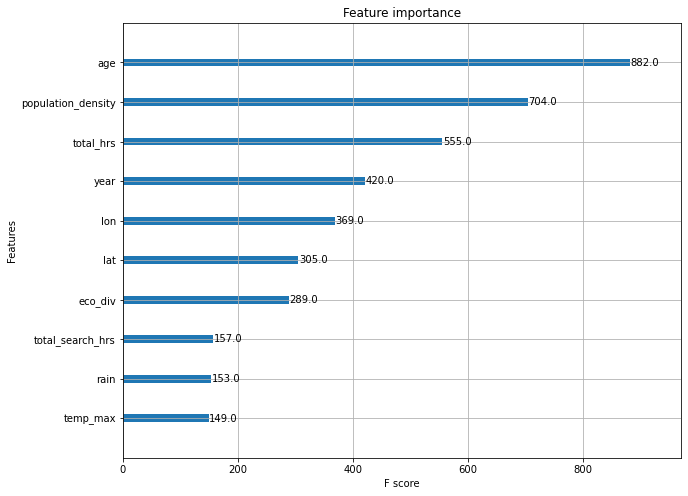

In [14]:
plt.rcParams['figure.figsize'] = (10, 8)
xgb.plot_importance(rf_xgb1, importance_type = 'weight', max_num_features = 10)

<AxesSubplot:>

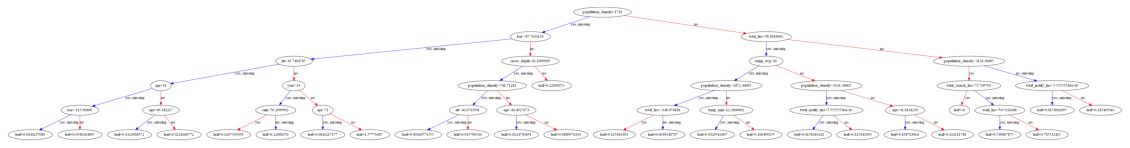

In [15]:
plt.rcParams['figure.figsize'] = (20, 100)
xgb.plot_tree(rf_xgb1)

In [ ]:
tune_search1.best_estimator_.save_model("rf1.json")
print(tune_search1.best_estimator_)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
xgb.plot_importance(tune_search1.best_estimator_, importance_type = 'weight', max_num_features = 10)

In [ ]:
plt.rcParams['figure.figsize'] = (20, 100)
xgb.plot_tree(tune_search1.best_estimator_)

### Standard Data, Boosted Regression

In [ ]:
Xc = model_data_cat.loc[~model_data_cat['dist_mi'].isna(), :].drop('dist_mi', axis = 1)
yc = model_data_cat.loc[~model_data_cat['dist_mi'].isna(), 'dist_mi']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size = 0.2, random_state = 1000)
# XYc_dmatrix = xgb.DMatrix(Xc, yc, enable_categorical = True, missing = np.NaN)

param_distributions = {
    'learning_rate':     [0.06196200767784121], 
    'max_depth':         [3], 
    'n_estimators':      [148], 
    'reg_alpha':         uniform(0, 0.01)
}
"""
param_distributions = {
    'learning_rate': uniform(), 
    'max_depth':     randint(2,   10), 
    'n_estimators':  randint(100, 500), 
    'reg_alpha':     uniform(0,   100)
}
"""
reg_xgb0 = xgb.XGBRegressor(tree_method = 'gpu_hist',      enable_categorical = True, \
                            predictor   = 'gpu_predictor', random_state       = 1000)

tune_search2 = TuneSearchCV(reg_xgb0, param_distributions, use_gpu = True, \
                            n_trials = 100, verbose = 2, time_budget_s = 1800, \
                            scoring  = scores, refit = 'r2') # , random_state = 1000
tune_search2.fit(Xc_train, yc_train)

reg_xgb_pred   = tune_search2.predict(Xc_test)
reg_xgb_params = tune_search2.best_params_

## metrics
reg_xgb_mae  = mean_absolute_error(yc_test, reg_xgb_pred)
reg_xgb_mse  = mean_squared_error(yc_test,  reg_xgb_pred)
reg_xgb_rmse = mean_squared_error(yc_test,  reg_xgb_pred, squared = False)
reg_xgb_r2   = r2_score(yc_test, reg_xgb_pred)

print("MAE:  {:.5f}".format(reg_xgb_mae))
print("MSE:  {:.5f}".format(reg_xgb_mse))
print("RMSE: {:.5f}".format(reg_xgb_rmse))
print("R\u00b2:   {:.5f}".format(reg_xgb_r2))

In [ ]:
reg_xgb_params

In [ ]:
reg_xgb0 = xgb.XGBRFRegressor(learning_rate= 0.06196200767784121, n_estimators=148, n_jobs=16, \
                            max_depth = 3, predictor='gpu_predictor', random_state=1000, \
                            reg_alpha=0, scale_pos_weight=1, tree_method='gpu_hist')
reg_xgb0.fit(Xc_train, yc_train)
reg_xgb0_pred   = reg_xgb0.predict(Xc_test)
print("MAE:  {:.5f}".format(mean_absolute_error(yc_test, reg_xgb0_pred)))
print("MSE:  {:.5f}".format(mean_squared_error(yc_test,  reg_xgb0_pred)))
print("RMSE: {:.5f}".format(mean_squared_error(yc_test,  reg_xgb0_pred, squared = False)))
print("R\u00b2:   {:.5f}".format(r2_score(yc_test, reg_xgb0_pred)))
reg_xgb0.save_model("reg0.json")

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
xgb.plot_importance(reg_xgb0, importance_type = 'weight', max_num_features = 10)

In [ ]:
plt.rcParams['figure.figsize'] = (20, 80)
xgb.plot_tree(reg_xgb0)

In [ ]:
tune_search2.best_estimator_.save_model("reg0.json")
print(tune_search2.best_estimator_)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
xgb.plot_importance(tune_search2.best_estimator_, importance_type = 'weight', max_num_features = 10)

In [ ]:
plt.rcParams['figure.figsize'] = (20, 80)
xgb.plot_tree(tune_search2.best_estimator_)

### KNN (k = 1) Imputed Data, Boosted Regression

In [ ]:
Xck = knn_impute_data.drop('dist_mi', axis = 1)
yck = knn_impute_data['dist_mi']
Xck_train, Xck_test, yck_train, yck_test = train_test_split(Xck, yck, test_size = 0.2, random_state = 1000)
# XYc_dmatrix = xgb.DMatrix(Xc, yc, enable_categorical = True, missing = np.NaN)

param_distributions = {
    'learning_rate': uniform(0.02, 0.03), 
    'max_depth':     [3],
    'n_estimators': randint(280,  320), 
    'reg_alpha':    uniform(0.03, 0.05)
}
"""
param_distributions = {
    'learning_rate': uniform(), 
    'max_depth':     randint(2,   10), 
    'n_estimators':  randint(100, 500), 
    'reg_alpha':     uniform(0,   100)
}
"""
reg_xgb1 = xgb.XGBRegressor(tree_method = 'gpu_hist',      enable_categorical = True, \
                            predictor   = 'gpu_predictor', random_state       = 1000)

tune_search3 = TuneSearchCV(reg_xgb1, param_distributions, use_gpu = True, \
                            n_trials = 100, verbose = 2, time_budget_s = 1800, \
                            scoring  = scores, refit = 'r2')
tune_search3.fit(Xck_train, yck_train)

reg_xgb_pred_ck   = tune_search3.predict(Xck_test)
reg_xgb_ck_params = tune_search3.best_params_

## metrics
reg_xgb_mae_ck  = mean_absolute_error(yck_test, reg_xgb_pred_ck)
reg_xgb_mse_ck  = mean_squared_error(yck_test,  reg_xgb_pred_ck)
reg_xgb_rmse_ck = mean_squared_error(yck_test,  reg_xgb_pred_ck, squared = False)
reg_xgb_r2_ck   = r2_score(yck_test, reg_xgb_pred_ck)

print("MAE:  {:.5f}".format(reg_xgb_mae_ck))
print("MSE:  {:.5f}".format(reg_xgb_mse_ck))
print("RMSE: {:.5f}".format(reg_xgb_rmse_ck))
print("R\u00b2:   {:.5f}".format(reg_xgb_r2_ck))

In [ ]:
reg_xgb_ck_params

In [ ]:
reg_xgb1 = xgb.XGBRegressor(learning_rate= 0.09066505982887307, n_estimators=130, n_jobs=16, max_depth=3, \
                            predictor='gpu_predictor', random_state=1000, reg_alpha=0.0010597853897286237, \
                            tree_method='gpu_hist')
reg_xgb1.fit(Xck_train, yck_train)
reg_xgb1_pred = reg_xgb1.predict(Xck_test)
print("MAE:  {:.5f}".format(mean_absolute_error(yck_test, reg_xgb1_pred)))
print("MSE:  {:.5f}".format(mean_squared_error(yck_test,  reg_xgb1_pred)))
print("RMSE: {:.5f}".format(mean_squared_error(yck_test,  reg_xgb1_pred, squared = False)))
print("R\u00b2:   {:.5f}".format(r2_score(yck_test, reg_xgb1_pred)))
reg_xgb1.save_model("reg1.json")

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
xgb.plot_importance(reg_xgb1, importance_type = 'weight', max_num_features = 10)

In [ ]:
plt.rcParams['figure.figsize'] = (20, 80)
xgb.plot_tree(reg_xgb1)

In [ ]:
tune_search3.best_estimator_.save_model("reg1.json")
print(tune_search3.best_estimator_)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
xgb.plot_importance(tune_search3.best_estimator_, importance_type = 'weight', max_num_features = 10)

In [ ]:
plt.rcParams['figure.figsize'] = (20, 80)
xgb.plot_tree(tune_search3.best_estimator_)

## Treat Predictor as Categorical

Searches for search and rescue attempts generally are not precise affairs; what if the distance to search were binned into categories, in order to give searches approximate guidelines on how far to search?

In [ ]:
model_data_catpred = pd.read_csv(latest_file('model_data_catnumeric'), low_memory = False)\
                       .set_index('id').drop('outcome', axis = 1)
knn_impute_catpred = pd.read_csv(latest_file('knn_impute_data'),       low_memory = False)\
                       .set_index('id').drop('outcome', axis = 1)
rf_impute_catpred  = pd.read_csv(latest_file('rf_impute_data'),        low_memory = False)\
                       .set_index('id').drop('outcome', axis = 1)

model_data_catpred['dist_mi'] = pd.cut(model_data_catpred['dist_mi'], \
                                       bins = [0, 1, 2, 5, 10, 1000], 
                                       labels = [2, 1, 0, -1, -2])
knn_impute_catpred['dist_mi'] = pd.cut(knn_impute_catpred['dist_mi'], \
                                       bins = [0, 1, 2, 5, 10, 1000], 
                                       labels = [2, 1, 0, -1, -2])
rf_impute_catpred['dist_mi']  = pd.cut(rf_impute_catpred['dist_mi'], \
                                       bins = [0, 1, 2, 5, 10, 1000], 
                                       labels = [2, 1, 0, -1, -2])
def convert_categorical(df, list_cats):
    for col in list_cats:
        df[col] = df[col].astype('category')
        label = LabelEncoder()
        label.fit(list(df[col].values))
        df[col] = label.transform(list(df[col].values))
    return df
## excluding 'outcome'
cat_cols_incl_dist = [i for i in model_data.columns if i.startswith('cat')] + \
                     ['dist_mi', 'eco_div', 'month', 'season', 'state', 'terrain', 'year']

model_data_catpred = convert_categorical(model_data_catpred, cat_cols_incl_dist)
knn_impute_catpred = convert_categorical(knn_impute_catpred, cat_cols_incl_dist)
rf_impute_catpred  = convert_categorical(rf_impute_catpred,  cat_cols_incl_dist)

### Standard Data, Random Forest Classification

In [ ]:
Xcat = model_data_catpred.loc[~model_data_catpred['dist_mi'].isna(), :].drop('dist_mi', axis = 1)
ycat = model_data_catpred.loc[~model_data_catpred['dist_mi'].isna(), 'dist_mi']
Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(Xcat, ycat, test_size = 0.2, random_state = 1000)

param_distributions = {
    'learning_rate': uniform(0.6, 0.3), 
    'max_depth':     [6], 
    'n_estimators':  randint(160, 180), 
    'reg_alpha':     uniform(0.7, 0.1)
}
"""
param_distributions = {
    'learning_rate': uniform(), 
    'max_depth':     randint(2,   10), 
    'n_estimators':  randint(100, 500), 
    'reg_alpha':     uniform(0,   100)
}
"""
rf_xgb2 = xgb.XGBRFClassifier(tree_method = 'gpu_hist',      enable_categorical = True, \
                              predictor   = 'gpu_predictor', random_state       = 1000, \
                              objective   = 'mlogloss')

tune_search4 = TuneSearchCV(rf_xgb2, param_distributions, use_gpu = True, \
                            n_trials = 100, verbose = 2, time_budget_s = 1200)
tune_search4.fit(Xcat_train, ycat_train)

rf_xgb2_pred   = tune_search4.predict(Xcat_test)
rf_xgb2_params = tune_search4.best_params_

## metrics
rf_xgb2_acc = accuracy_score(ycat_test,  rf_xgb2_pred, normalize = True)
rf_xgb2_f1  = f1_score(ycat_test,        rf_xgb2_pred, average   = 'macro')
rf_xgb2_pre = precision_score(ycat_test, rf_xgb2_pred, average   = 'macro')
rf_xgb2_rec = recall_score(ycat_test,    rf_xgb2_pred, average   = 'macro')

print("Accuracy:  {:.5f}".format(rf_xgb2_acc))
print("F-score:   {:.5f}".format(rf_xgb2_f1))
print("Precision: {:.5f}".format(rf_xgb2_pre))
print("Recall:    {:.5f}".format(rf_xgb2_rec))

In [ ]:
Xcat = model_data_catpred.loc[~model_data_catpred['dist_mi'].isna(), :].drop('dist_mi', axis = 1)
ycat = model_data_catpred.loc[~model_data_catpred['dist_mi'].isna(), 'dist_mi']
Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(Xcat, ycat, test_size = 0.2, random_state = 1000)

rf_xgb2 = xgb.XGBRFClassifier(learning_rate=0.7382878697739075, n_estimators=169, n_jobs=16, max_depth=6, \
                              predictor='gpu_predictor', random_state=1000, reg_alpha=0.7396376836352886, \
                              tree_method='gpu_hist')
rf_xgb2.fit(Xcat_train, ycat_train)
rf_xgb2_pred = rf_xgb2.predict(Xcat_test)
print("Accuracy:  {:.5f}".format(accuracy_score(ycat_test,  rf_xgb2_pred, normalize = True)))
print("F-score:   {:.5f}".format(f1_score(ycat_test,        rf_xgb2_pred, average   = 'macro')))
print("Precision: {:.5f}".format(precision_score(ycat_test, rf_xgb2_pred, average   = 'macro')))
print("Recall:    {:.5f}".format(recall_score(ycat_test,    rf_xgb2_pred, average   = 'macro')))
rf_xgb2.save_model("rf2.json")

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
xgb.plot_importance(rf_xgb2, importance_type = 'weight', max_num_features = 10)

In [ ]:
plt.rcParams['figure.figsize'] = (20, 80)
xgb.plot_tree(rf_xgb2)

In [ ]:
rf_xgb2_params

In [ ]:
tune_search4.best_estimator_.save_model("rf2.json")
print(tune_search4.best_estimator_)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
xgb.plot_importance(tune_search4.best_estimator_, importance_type = 'weight', max_num_features = 10)

In [ ]:
plt.rcParams['figure.figsize'] = (20, 80)
xgb.plot_tree(tune_search4.best_estimator_)

### KNN (k = 1) Imputed Data, Random Forest Classification

In [ ]:
Xcatk = knn_impute_catpred.drop('dist_mi', axis = 1)
ycatk = knn_impute_catpred['dist_mi']
Xcatk_train, Xcatk_test, ycatk_train, ycatk_test = train_test_split(Xcatk, ycatk, test_size = 0.2, random_state = 1000)

param_distributions = {
    'learning_rate': uniform(0.0,  0.3), 
    'max_depth':     [9], 
    'n_estimators':  randint(60,   120), 
    'reg_alpha':     uniform(0.3,  0.5)
}

rf_xgb3 = xgb.XGBRFClassifier(tree_method = 'gpu_hist',      enable_categorical = True, \
                              predictor   = 'gpu_predictor', random_state       = 1000, \
                              objective   = 'multi:softprob')

tune_search5 = TuneSearchCV(rf_xgb3, param_distributions, use_gpu = True, \
                            n_trials = 100, verbose = 2, time_budget_s = 1200)
tune_search5.fit(Xcatk_train, ycatk_train)

rf_xgb3_pred   = tune_search5.predict(Xcatk_test)
rf_xgb3_params = tune_search5.best_params_

## metrics
rf_xgb3_acc = accuracy_score(ycatk_test,  rf_xgb3_pred, normalize = True)
rf_xgb3_f1  = f1_score(ycatk_test,        rf_xgb3_pred, average   = 'macro')
rf_xgb3_pre = precision_score(ycatk_test, rf_xgb3_pred, average   = 'macro')
rf_xgb3_rec = recall_score(ycatk_test,    rf_xgb3_pred, average   = 'macro')

print("Accuracy:  {:.5f}".format(rf_xgb3_acc))
print("F-score:   {:.5f}".format(rf_xgb3_f1))
print("Precision: {:.5f}".format(rf_xgb3_pre))
print("Recall:    {:.5f}".format(rf_xgb3_rec))

In [ ]:
rf_xgb3_params

In [ ]:
Xcatk = knn_impute_catpred.drop('dist_mi', axis = 1)
ycatk = knn_impute_catpred['dist_mi']
Xcatk_train, Xcatk_test, ycatk_train, ycatk_test = train_test_split(Xcatk, ycatk, test_size = 0.2, random_state = 1000)

rf_xgb3 = xgb.XGBRFClassifier(learning_rate=0.21703389812478247, n_estimators=102, n_jobs=16, max_depth=9, \
                              predictor='gpu_predictor', random_state=1000, reg_alpha=0.689362851255999, \
                              tree_method='gpu_hist')
rf_xgb3.fit(Xcat_train, ycat_train)
rf_xgb3_pred = rf_xgb2.predict(Xcat_test)
print("Accuracy:  {:.5f}".format(accuracy_score(ycat_test,  rf_xgb3_pred, normalize = True)))
print("F-score:   {:.5f}".format(f1_score(ycat_test,        rf_xgb3_pred, average   = 'macro')))
print("Precision: {:.5f}".format(precision_score(ycat_test, rf_xgb3_pred, average   = 'macro')))
print("Recall:    {:.5f}".format(recall_score(ycat_test,    rf_xgb3_pred, average   = 'macro')))
rf_xgb3.save_model("rf2.json")

In [ ]:
tune_search5.best_estimator_.save_model("rf3.json")
print(tune_search5.best_estimator_)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
xgb.plot_importance(tune_search5.best_estimator_, importance_type = 'weight', max_num_features = 10)

In [ ]:
plt.rcParams['figure.figsize'] = (20, 80)
xgb.plot_tree(tune_search5.best_estimator_)

### Standard Data, Boosted Classification

In [ ]:
Xcat = model_data_catpred.loc[~model_data_catpred['dist_mi'].isna(), :].drop('dist_mi', axis = 1)
ycat = model_data_catpred.loc[~model_data_catpred['dist_mi'].isna(), 'dist_mi']
Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(Xcat, ycat, test_size = 0.2, random_state = 1000)

param_distributions = {
    'learning_rate': uniform(0,   0.04), 
    'max_depth':     randint(3,   5), 
    'n_estimators':  randint(175, 325), 
    'reg_alpha':     uniform(0.1, 0.9)
}

reg_xgb2 = xgb.XGBClassifier(tree_method = 'gpu_hist',      enable_categorical = True, \
                             predictor   = 'gpu_predictor', random_state       = 1000, \
                             objective   = 'mlogloss')

tune_search6 = TuneSearchCV(reg_xgb2, param_distributions, use_gpu = True, \
                            n_trials = 100, verbose = 2, time_budget_s = 1200)
tune_search6.fit(Xcat_train, ycat_train)

reg_xgb2_pred   = tune_search6.predict(Xcat_test)
reg_xgb2_params = tune_search6.best_params_

## metrics
reg_xgb2_acc = accuracy_score(ycat_test,  reg_xgb2_pred, normalize = True)
reg_xgb2_f1  = f1_score(ycat_test,        reg_xgb2_pred, average   = 'macro')
reg_xgb2_pre = precision_score(ycat_test, reg_xgb2_pred, average   = 'macro')
reg_xgb2_rec = recall_score(ycat_test,    reg_xgb2_pred, average   = 'macro')

print("Accuracy:  {:.5f}".format(reg_xgb2_acc))
print("F-score:   {:.5f}".format(reg_xgb2_f1))
print("Precision: {:.5f}".format(reg_xgb2_pre))
print("Recall:    {:.5f}".format(reg_xgb2_rec))

In [ ]:
Xcat = model_data_catpred.loc[~model_data_catpred['dist_mi'].isna(), :].drop('dist_mi', axis = 1)
ycat = model_data_catpred.loc[~model_data_catpred['dist_mi'].isna(), 'dist_mi']
Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(Xcat, ycat, test_size = 0.2, random_state = 1000)

reg_xgb2 = xgb.XGBClassifier(learning_rate=0.026041765769964, n_estimators=196, n_jobs=16, max_depth=4, \
                             predictor='gpu_predictor', random_state=1000, reg_alpha=0.9384038232797361, \
                             tree_method='gpu_hist')
reg_xgb2.fit(Xcat_train, ycat_train)
reg_xgb2_pred = reg_xgb2.predict(Xcat_test)
print("Accuracy:  {:.5f}".format(accuracy_score(ycat_test,  reg_xgb2, normalize = True)))
print("F-score:   {:.5f}".format(f1_score(ycat_test,        reg_xgb2, average   = 'macro')))
print("Precision: {:.5f}".format(precision_score(ycat_test, reg_xgb2, average   = 'macro')))
print("Recall:    {:.5f}".format(recall_score(ycat_test,    reg_xgb2, average   = 'macro')))
reg_xgb2.save_model("reg2.json")

In [ ]:
reg_xgb2_params

In [ ]:
tune_search6.best_estimator_.save_model("reg2.json")
print(tune_search6.best_estimator_)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
xgb.plot_importance(tune_search6.best_estimator_, importance_type = 'weight', max_num_features = 10)

In [ ]:
plt.rcParams['figure.figsize'] = (20, 80)
xgb.plot_tree(tune_search6.best_estimator_)

### KNN (k = 1) Imputed Data, Boosted Classification

In [ ]:
Xcatk = knn_impute_catpred.drop('dist_mi', axis = 1)
ycatk = knn_impute_catpred['dist_mi']
Xcatk_train, Xcatk_test, ycatk_train, ycatk_test = train_test_split(Xcatk, ycatk, test_size = 0.2, random_state = 1000)

param_distributions = {
    'learning_rate': uniform(0.3, 0.3), 
    'max_depth':     randint(8,   9), 
    'n_estimators':  randint(100, 35), 
    'reg_alpha':     uniform(0.0, 0.4)
}

reg_xgb3 = xgb.XGBClassifier(tree_method = 'gpu_hist',      enable_categorical = True, \
                              predictor  = 'gpu_predictor', random_state       = 1000, \
                              objective  = 'mlogloss')

tune_search7 = TuneSearchCV(reg_xgb3, param_distributions, use_gpu = True, \
                            n_trials = 50, verbose = 2, time_budget_s = 1200)
tune_search7.fit(Xcatk_train, ycatk_train)

reg_xgb3_pred   = tune_search7.predict(Xcatk_test)
reg_xgb3_params = tune_search7.best_params_

## metrics
reg_xgb3_acc = accuracy_score(ycatk_test,  reg_xgb3_pred, normalize = True)
reg_xgb3_f1  = f1_score(ycatk_test,        reg_xgb3_pred, average   = 'macro')
reg_xgb3_pre = precision_score(ycatk_test, reg_xgb3_pred, average   = 'macro')
reg_xgb3_rec = recall_score(ycatk_test,    reg_xgb3_pred, average   = 'macro')

print("Accuracy:  {:.5f}".format(reg_xgb3_acc))
print("F-score:   {:.5f}".format(reg_xgb3_f1))
print("Precision: {:.5f}".format(reg_xgb3_pre))
print("Recall:    {:.5f}".format(reg_xgb3_rec))

In [ ]:
Xcatk = knn_impute_catpred.drop('dist_mi', axis = 1)
ycatk = knn_impute_catpred['dist_mi']
Xcatk_train, Xcatk_test, ycatk_train, ycatk_test = train_test_split(Xcatk, ycatk, test_size = 0.2, random_state = 1000)

reg_xgb3 = xgb.XGBClassifier(learning_rate=0.37015426893640047, n_estimators=123, n_jobs=16, max_depth=9, \
                             predictor='gpu_predictor', random_state=1000, reg_alpha=0.09465784839517966, \
                             tree_method='gpu_hist')
reg_xgb3.fit(Xcatk_test, ycatk_test)
reg_xgb3_pred = reg_xgb3.predict(Xcatk_test)
print("Accuracy:  {:.5f}".format(accuracy_score(ycatk_test,  reg_xgb3_pred, normalize = True)))
print("F-score:   {:.5f}".format(f1_score(ycatk_test,        reg_xgb3_pred, average   = 'macro')))
print("Precision: {:.5f}".format(precision_score(ycatk_test, reg_xgb3_pred, average   = 'macro')))
print("Recall:    {:.5f}".format(recall_score(ycatk_test,    reg_xgb3_pred, average   = 'macro')))
reg_xgb3.save_model("reg3.json")

In [ ]:
rf_xgb3_params

In [ ]:
tune_search7.best_estimator_.save_model("reg3.json")
print(tune_search7.best_estimator_)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
xgb.plot_importance(tune_search7.best_estimator_, importance_type = 'weight', max_num_features = 10)

In [ ]:
plt.rcParams['figure.figsize'] = (20, 80)
xgb.plot_tree(tune_search7.best_estimator_)

In [ ]:
## subset where there is missing

test_impute_data = model_data.copy()
n_neighbors = [1, 2, 3, 5, 8, 10, 12]

fig, ax = plt.subplots(figsize = (16, 8))
# Plot the original distribution
sns.kdeplot(model_data['temp_max'], label="Original Distribution")
for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors = k)
    test_impute_data.loc[:, :] = knn_imp.fit_transform(model_data)
    sns.kdeplot(test_impute_data['temp_max'], label = f"Imputed Dist with k={k}")

plt.legend();

In [ ]:
fig, ax = plt.subplots(figsize = (16, 8))
for var in knn_impute_data.columns:
    sns.kdeplot(test_impute_data[var], label = f"Imputed Dist for var={var}")
plt.xlim((-3, 3))
plt.ylim((0, 10))
plt.legend();

In [ ]:
fig, ax = plt.subplots(figsize = (16, 8))
for var in model_data.columns:
    sns.kdeplot(model_data[var], label = f"Original Dist for var={var}")
plt.xlim((-3, 3))
plt.ylim((0, 10))
plt.legend();